In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D,GlobalMaxPooling2D, Flatten, Dropout, LeakyReLU
from tensorflow.python.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.optimizers import SGD

In [3]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [4]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [6]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [7]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [8]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [9]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['acc']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss, 'o', color='b', label='Training Loss')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')
    plt.title('Training and Test loss')
    plt.legend()
    plt.show()

In [10]:
train_data_dir='/home/deepstation/tensorflow-for-poets-2/tf_files/flower_photos'
test_data_dir='/home/deepstation/tensorflow-for-poets-2/tf_files/testing'

In [11]:
input_shape=(299, 299)

In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [13]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

(0, 'input_1')
(1, 'conv2d_1')
(2, 'batch_normalization_1')
(3, 'activation_1')
(4, 'conv2d_2')
(5, 'batch_normalization_2')
(6, 'activation_2')
(7, 'conv2d_3')
(8, 'batch_normalization_3')
(9, 'activation_3')
(10, 'max_pooling2d_1')
(11, 'conv2d_4')
(12, 'batch_normalization_4')
(13, 'activation_4')
(14, 'conv2d_5')
(15, 'batch_normalization_5')
(16, 'activation_5')
(17, 'max_pooling2d_2')
(18, 'conv2d_9')
(19, 'batch_normalization_9')
(20, 'activation_9')
(21, 'conv2d_7')
(22, 'conv2d_10')
(23, 'batch_normalization_7')
(24, 'batch_normalization_10')
(25, 'activation_7')
(26, 'activation_10')
(27, 'average_pooling2d_1')
(28, 'conv2d_6')
(29, 'conv2d_8')
(30, 'conv2d_11')
(31, 'conv2d_12')
(32, 'batch_normalization_6')
(33, 'batch_normalization_8')
(34, 'batch_normalization_11')
(35, 'batch_normalization_12')
(36, 'activation_6')
(37, 'activation_8')
(38, 'activation_11')
(39, 'activation_12')
(40, 'mixed0')
(41, 'conv2d_16')
(42, 'batch_normalization_16')
(43, 'activation_16')
(44, 'c

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
    generator_train = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(input_shape),
    batch_size=20,
    shuffle=True,
    class_mode='categorical'
)

Found 1789 images belonging to 4 classes.


In [18]:
    generator_test = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape),
    batch_size=20,
    shuffle=True,
    class_mode='categorical'
)

Found 80 images belonging to 4 classes.


In [19]:
steps_test = generator_test.n / 20
steps_test

4

In [20]:
image_paths_train = path_join(train_data_dir, generator_train.filenames)
image_paths_test = path_join(test_data_dir, generator_test.filenames)

In [21]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [22]:
class_names = list(generator_train.class_indices.keys())
class_names

['acute', 'subacute', 'no eczema', 'chronic']

In [23]:
num_classes = generator_train.num_classes
num_classes

4

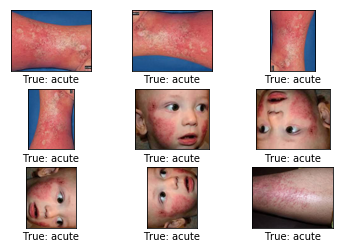

In [24]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [25]:
from sklearn.utils.class_weight import compute_class_weight

In [26]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [27]:
class_weight

array([0.73682043, 1.06742243, 1.22199454, 1.12657431])

In [28]:
class_names

['acute', 'subacute', 'no eczema', 'chronic']

In [29]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [30]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [33]:
print_layer_trainable()

False:	input_1
False:	conv2d_1
False:	batch_normalization_1
False:	activation_1
False:	conv2d_2
False:	batch_normalization_2
False:	activation_2
False:	conv2d_3
False:	batch_normalization_3
False:	activation_3
False:	max_pooling2d_1
False:	conv2d_4
False:	batch_normalization_4
False:	activation_4
False:	conv2d_5
False:	batch_normalization_5
False:	activation_5
False:	max_pooling2d_2
False:	conv2d_9
False:	batch_normalization_9
False:	activation_9
False:	conv2d_7
False:	conv2d_10
False:	batch_normalization_7
False:	batch_normalization_10
False:	activation_7
False:	activation_10
False:	average_pooling2d_1
False:	conv2d_6
False:	conv2d_8
False:	conv2d_11
False:	conv2d_12
False:	batch_normalization_6
False:	batch_normalization_8
False:	batch_normalization_11
False:	batch_normalization_12
False:	activation_6
False:	activation_8
False:	activation_11
False:	activation_12
False:	mixed0
False:	conv2d_16
False:	batch_normalization_16
False:	activation_16
False:	conv2d_14
False:	conv2d_17
False:	

In [34]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [35]:
epochs = 10
steps_per_epoch = 100

In [36]:
history = model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/10
100/100 [==============================] - 29s 286ms/step - loss: 1.3512 - acc: 0.3430 - val_loss: 1.4883 - val_acc: 0.2875
Epoch 2/10
100/100 [==============================] - 27s 266ms/step - loss: 1.1943 - acc: 0.4465 - val_loss: 1.5744 - val_acc: 0.3000
Epoch 3/10
100/100 [==============================] - 26s 256ms/step - loss: 1.0816 - acc: 0.5153 - val_loss: 1.7283 - val_acc: 0.3250
Epoch 4/10
100/100 [==============================] - 24s 237ms/step - loss: 0.9794 - acc: 0.5620 - val_loss: 1.7023 - val_acc: 0.4125
Epoch 5/10
100/100 [==============================] - 26s 260ms/step - loss: 0.9239 - acc: 0.6136 - val_loss: 2.1417 - val_acc: 0.3250
Epoch 6/10
100/100 [==============================] - 26s 264ms/step - loss: 0.9011 - acc: 0.6187 - val_loss: 1.7893 - val_acc: 0.3625
Epoch 7/10
100/100 [==============================] - 24s 240ms/step - loss: 0.8427 - acc: 0.6560 - val_loss: 1.8152 - val_acc: 0.4000
Epoch 8/10
100/100 [==============================] - 2

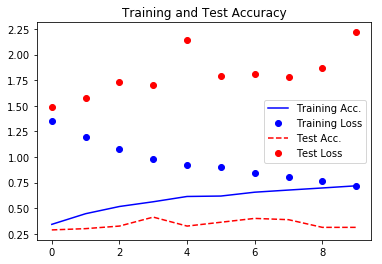

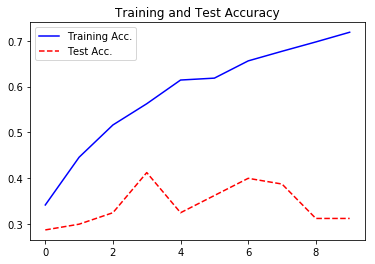

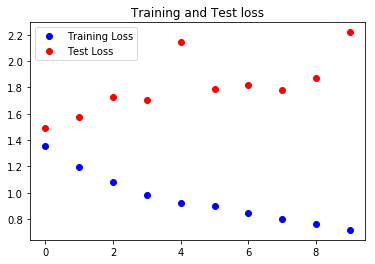

In [37]:
plot_training_history(history)

In [38]:
result = model.evaluate_generator(generator_test, steps=steps_test)

In [39]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 31.25%


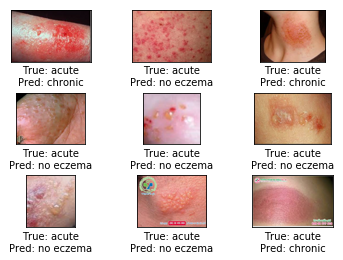

Confusion matrix:
[[10  0  7  3]
 [ 9  0  6  5]
 [12  0  3  5]
 [12  0  5  3]]
(0) acute
(1) subacute
(2) no eczema
(3) chronic


In [40]:
example_errors()

In [41]:
resultt=model.predict_generator(generator_test, steps=steps_test)

In [42]:
print(resultt)

[[2.19346941e-01 3.30372564e-02 2.57249310e-04 7.47358561e-01]
 [3.03804815e-01 1.41644374e-01 7.06257448e-02 4.83925074e-01]
 [8.18492770e-01 1.32305743e-02 1.33198947e-01 3.50777581e-02]
 [5.15910983e-03 9.42313363e-06 9.94742870e-01 8.85483605e-05]
 [6.27551794e-01 3.69979534e-03 1.15888096e-01 2.52860278e-01]
 [8.90794635e-01 3.59902740e-03 8.43479112e-02 2.12583710e-02]
 [2.79569298e-01 4.87797806e-04 7.16005445e-01 3.93748516e-03]
 [1.01532407e-01 4.59480798e-03 8.74521315e-01 1.93515513e-02]
 [1.29441753e-01 2.14553392e-03 8.50363910e-01 1.80487800e-02]
 [5.38599014e-01 5.30871446e-04 4.56418365e-01 4.45175311e-03]
 [6.43216848e-01 4.34930995e-02 2.98631698e-01 1.46583915e-02]
 [8.41778815e-01 9.88994911e-03 1.33493662e-01 1.48375547e-02]
 [2.89456427e-01 3.25605050e-02 3.98354186e-03 6.73999548e-01]
 [7.67671287e-01 3.09671718e-03 2.29310095e-02 2.06301048e-01]
 [7.33092070e-01 1.00758910e-01 8.18960592e-02 8.42529088e-02]
 [5.28979659e-01 7.51307642e-04 4.48490083e-01 2.177897

In [43]:
print_layer_trainable()

False:	input_1
False:	conv2d_1
False:	batch_normalization_1
False:	activation_1
False:	conv2d_2
False:	batch_normalization_2
False:	activation_2
False:	conv2d_3
False:	batch_normalization_3
False:	activation_3
False:	max_pooling2d_1
False:	conv2d_4
False:	batch_normalization_4
False:	activation_4
False:	conv2d_5
False:	batch_normalization_5
False:	activation_5
False:	max_pooling2d_2
False:	conv2d_9
False:	batch_normalization_9
False:	activation_9
False:	conv2d_7
False:	conv2d_10
False:	batch_normalization_7
False:	batch_normalization_10
False:	activation_7
False:	activation_10
False:	average_pooling2d_1
False:	conv2d_6
False:	conv2d_8
False:	conv2d_11
False:	conv2d_12
False:	batch_normalization_6
False:	batch_normalization_8
False:	batch_normalization_11
False:	batch_normalization_12
False:	activation_6
False:	activation_8
False:	activation_11
False:	activation_12
False:	mixed0
False:	conv2d_16
False:	batch_normalization_16
False:	activation_16
False:	conv2d_14
False:	conv2d_17
False:	

In [44]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [45]:
print_layer_trainable()

False:	input_1
False:	conv2d_1
False:	batch_normalization_1
False:	activation_1
False:	conv2d_2
False:	batch_normalization_2
False:	activation_2
False:	conv2d_3
False:	batch_normalization_3
False:	activation_3
False:	max_pooling2d_1
False:	conv2d_4
False:	batch_normalization_4
False:	activation_4
False:	conv2d_5
False:	batch_normalization_5
False:	activation_5
False:	max_pooling2d_2
False:	conv2d_9
False:	batch_normalization_9
False:	activation_9
False:	conv2d_7
False:	conv2d_10
False:	batch_normalization_7
False:	batch_normalization_10
False:	activation_7
False:	activation_10
False:	average_pooling2d_1
False:	conv2d_6
False:	conv2d_8
False:	conv2d_11
False:	conv2d_12
False:	batch_normalization_6
False:	batch_normalization_8
False:	batch_normalization_11
False:	batch_normalization_12
False:	activation_6
False:	activation_8
False:	activation_11
False:	activation_12
False:	mixed0
False:	conv2d_16
False:	batch_normalization_16
False:	activation_16
False:	conv2d_14
False:	conv2d_17
False:	

In [46]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [47]:
history = model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/10
100/100 [==============================] - 29s 289ms/step - loss: 1.0470 - acc: 0.5620 - val_loss: 2.8426 - val_acc: 0.3875
Epoch 2/10
100/100 [==============================] - 29s 289ms/step - loss: 0.6505 - acc: 0.7537 - val_loss: 1.6390 - val_acc: 0.4875
Epoch 3/10
100/100 [==============================] - 26s 262ms/step - loss: 0.4088 - acc: 0.8400 - val_loss: 3.4344 - val_acc: 0.4000
Epoch 4/10
100/100 [==============================] - 29s 294ms/step - loss: 0.3370 - acc: 0.8827 - val_loss: 3.4297 - val_acc: 0.4500
Epoch 5/10
100/100 [==============================] - 25s 246ms/step - loss: 0.2498 - acc: 0.9140 - val_loss: 2.8324 - val_acc: 0.4875
Epoch 6/10
100/100 [==============================] - 26s 260ms/step - loss: 0.2208 - acc: 0.9298 - val_loss: 2.8346 - val_acc: 0.4375
Epoch 7/10
100/100 [==============================] - 27s 275ms/step - loss: 0.2179 - acc: 0.9247 - val_loss: 2.2393 - val_acc: 0.4500
Epoch 8/10
100/100 [==============================] - 2

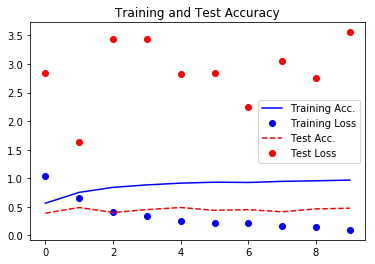

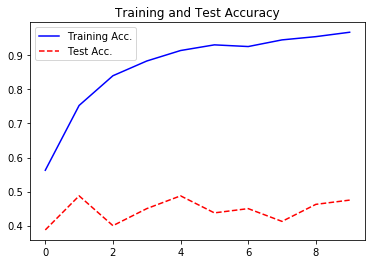

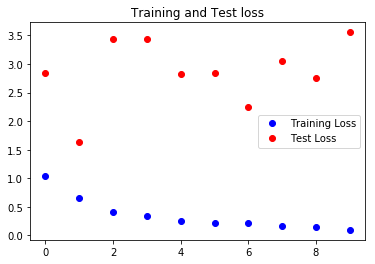

In [48]:
plot_training_history(history)

In [49]:
result = model.evaluate_generator(generator_test, steps=steps_test)

In [50]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 47.50%


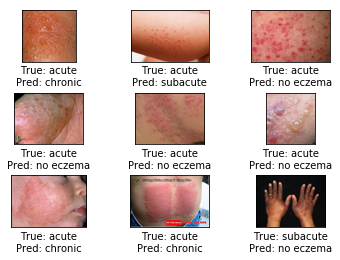

Confusion matrix:
[[12  1  4  3]
 [ 5  3  6  6]
 [ 6  1  4  9]
 [ 8  0  4  8]]
(0) acute
(1) subacute
(2) no eczema
(3) chronic


In [51]:
example_errors()

In [ ]:
resulttt=model.predict_generator(generator_test, steps=steps_test)

In [ ]:
print(resulttt)